In [158]:
# import os
# os.chdir("../")

In [265]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score

In [264]:
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [160]:
from scr.util import *

# Base Infomation

In [161]:
df = pd.read_csv("data/train.csv")

In [162]:
df.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,customer_info,ProdTaken
0,0,50歳,Self Enquiry,2,900秒,Large Business,male,1.0,4.0,Basic,3.0,5,1,4,Executive,253905.0,未婚 車未所持 子供なし,1
1,1,56歳,Company Invited,1,14分,Salaried,Male,1.0,4.0,Standard,3.0,2,1,4,Senior Manager,404475.0,"離婚済み,車あり,子供無し",0
2,2,NaN,Self Enquiry,1,10分,Large Business,Female,1.0,3.0,Basic,3.0,4,0,4,Executive,278145.0,"結婚済み、自動車未所有,子供なし",1
3,3,三十七歳,Self Enquiry,2,1080秒,Small Business,female,1.0,3.0,Standard,4.0,1,0,5,Senior Manager,326805.0,離婚済み、車所持、子供無し,0
4,4,48歳,Company Invited,3,1020秒,Small Business,female,1.0,3.0,Basic,4.0,4,0,4,Executive,258435.0,独身／車所持／無子,1


In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3489 non-null   int64  
 1   Age                     3389 non-null   object 
 2   TypeofContact           3483 non-null   object 
 3   CityTier                3489 non-null   int64  
 4   DurationOfPitch         3368 non-null   object 
 5   Occupation              3489 non-null   object 
 6   Gender                  3489 non-null   object 
 7   NumberOfPersonVisiting  3489 non-null   float64
 8   NumberOfFollowups       3456 non-null   float64
 9   ProductPitched          3489 non-null   object 
 10  PreferredPropertyStar   3489 non-null   float64
 11  NumberOfTrips           3467 non-null   object 
 12  Passport                3489 non-null   int64  
 13  PitchSatisfactionScore  3489 non-null   int64  
 14  Designation             3489 non-null   

In [164]:
df.describe()

,id,CityTier,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,Passport,PitchSatisfactionScore,ProdTaken
count,3489.000000,3489.000000,3489.000000,3456.000000,3489.000000,3489.000000,3489.000000,3489.000000
mean,1744.000000,1.697048,2.394669,7.765336,3.441101,0.102608,2.513901,0.142448
std,1007.331872,0.671500,0.726612,39.498670,0.599633,0.303490,1.115412,0.349559
min,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000,1.000000,0.000000
25%,872.000000,1.000000,2.000000,3.000000,3.000000,0.000000,2.000000,0.000000
50%,1744.000000,2.000000,2.000000,4.000000,3.000000,0.000000,2.000000,0.000000
75%,2616.000000,2.000000,3.000000,4.000000,4.000000,0.000000,3.000000,0.000000
max,3488.000000,3.000000,4.000000,600.000000,5.000000,1.000000,5.000000,1.000000


In [165]:
df.isna().sum()

id                          0
Age                       100
TypeofContact               6
CityTier                    0
DurationOfPitch           121
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups          33
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips              22
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome              56
customer_info               0
ProdTaken                   0
dtype: int64

In [166]:
tmp = ["TypeofContact", "Occupation", "Gender", "ProductPitched", "NumberOfTrips", "Designation", "customer_info"]
for column in tmp:
    print(column)
    print(df[column].unique(), "\n")

TypeofContact
['Self Enquiry' 'Company Invited' nan] 

Occupation
['Large Business' 'Salaried' 'Small Business'] 

Gender
['male' 'Male' 'Female' 'female' 'ｆｅｍａｌｅ' 'FEMALE' 'Ｍａｌｅ' 'Fe Male' 'MALE'
 'ｆｅ\u3000ｍａｌｅ' 'fe male' 'Ｆｅｍａｌｅ' 'ｍａｌｅ' 'FE MALE' 'Ｆｅ\u3000Ｍａｌｅ'
 'ＦＥＭＡＬＥ' 'ＦＥ\u3000ＭＡＬＥ' 'ＭＡＬＥ'] 

ProductPitched
['Basic' 'Standard' 'Super Deluxe' 'basic' 'SUPER DELUXE' 'super deluxe'
 'BASIC' 'Deluxe' 'deluxe' 'STANᗞARD' 'STANDARD' 'Вasic' 'DELUXE'
 'ꓢuper De|uxe' 'Ѕuper Deluxe' 'BAՏIC' 'Basıc' 'King' 'Super De|uxe'
 'king' 'standard' 'KING' 'BΑSIC' 'B𝖺sic' 'De|uxe' 'ᎠELUXE' 'Basiϲ'
 'de|u×e' 'Delu×e' 'Standar𝔡' 'Basi𝘤' 'Βasic' 'Տuper Deluxe' 'Staոdard'
 'BAꓢIC' 'ᗞeluxe' 'Տtandard' 'Βası𝘤' 'Kıng' 'Baｓic' 'basıc' 'super de|uxe'
 'Stand𝖺rd' 'S𝘵andard' '𐊡asic' 'St𝖺ndard' 'Super ᗞeluxe' 'de|uxe'
 'ｓuper deluxe' 'STANDARᎠ' 'Basiс' 'DΕLUXΕ' 'ꓢuper Deluxe' 'BASΙC'
 'ꓢtandard' 'В𝖺sic' 'Standa𝘳d' 'basiϲ' 'staոdard' 'Super Ꭰeluxe' 'DELUXΕ'
 'Ѕtandard' '𐊡asi𝘤' 'Ꭰeluxe' 'Kıոg' '𝙳eluxe' 'Kiոg' 'Βas

# Preprocessing

## NuLL

### Age -> age

In [167]:
df["Age"].unique()

array(['50歳', '56歳', nan, '三十七歳', '48歳', '19歳', '47歳', '49歳', '33歳',
       '３１歳', '51歳', '46歳', '４９歳', '53才', '20歳', '25歳', '五十三歳', '20代',
       '44歳', '30歳', '34歳', '29歳', '30代', '41歳', '50代', '52歳', '22歳',
       '３６歳', '28歳', '25才', '五十一歳', '48才', '38才', '三十三歳', '42際', '５０代',
       '35才', '59歳', '四十三歳', '32歳', '４２才', '53歳', '58歳', '40代', '二十六歳',
       '52際', '54歳', '59才', '29才', '21才', '57歳', '37歳', '35歳', '36才',
       '38歳', '３７歳', '50才', '51才', '43歳', '四十歳', '26歳', '31歳', '27歳',
       '40歳', '３４歳', '40際', '21歳', '24才', '45歳', '36歳', '41才', '38際',
       '18歳', '39歳', '４６歳', '４０代', '５５歳', '58際', '24歳', '41際', '三十一歳',
       '52才', '３０代', '28才', '55際', '60代', '27際', '３２歳', '60歳', '五十四歳',
       '29際', '三十四歳', '４７歳', '37際', '二十四歳', '四十七歳', '58才', '39才', '23才',
       '３３歳', '４２歳', '４５歳', '３９歳', '５４歳', '55歳', '42歳', '３８歳', '47才',
       '５１歳', '３９才', '51際', '二十七歳', '30才', '２６歳', '４０歳', '36際', '三十歳',
       '23歳', '二十二歳', '37才', '３０歳', '２８歳', '34才', '五十歳', '四十一歳', '５９歳',
       '

In [168]:
# 日本語をすべてInt型に変換
df["age"] = df["Age"].astype(str).apply(japanese_to_int)

# 欠損値を中央値で補完
# japanese_to_int関数により、欠損値は0と出力されている。
tmp = df[~(df["age"] == 0)]
df.loc[df["age"] == 0, "age"] = tmp["age"].median()

In [169]:
df["age"].unique()

array([50, 56, 38, 37, 48, 19, 47, 49, 33, 31, 51, 46, 53, 20, 25, 44, 30,
       34, 29, 41, 52, 22, 36, 28, 42, 35, 59, 43, 32, 58, 40, 26, 54, 21,
       57, 27, 24, 45, 18, 39, 55, 60, 23, 10, 61], dtype=int64)

### DurationOfPitch -> duration

In [170]:
df["DurationOfPitch"].unique()

array(['900秒', '14分', '10分', '1080秒', '1020秒', '16分', '840秒', '22分',
       '20分', '11分', '32分', '17分', '24分', '1380秒', '35分', '420秒', '5分',
       '480秒', '8分', '15分', '960秒', nan, '540秒', '26分', '13分', '12分',
       '21分', '25分', '720秒', '9分', '7分', '780秒', '6分', '18分', '31分',
       '600秒', '23分', '28分', '2160秒', '660秒', '1500秒', '1920秒', '27分',
       '33分', '360秒', '1320秒', '1740秒', '1680秒', '29分', '1620秒', '1440秒',
       '1800秒', '30分', '34分', '4分', '19分', '1860秒', '1260秒', '2100秒',
       '300秒', '2040秒', '1200秒', '1560秒', '1980秒', '36分', '1140秒'],
      dtype=object)

In [171]:
# 単位をすべて秒に統一
df["duration"] = df["DurationOfPitch"].dropna().apply(convert_to_second)

# 欠損値を中央値で補完
df["duration"] = df["duration"].fillna(df["duration"].median())

In [172]:
df["duration"].unique()

array([ 900.,  840.,  600., 1080., 1020.,  960., 1320., 1200.,  660.,
       1920., 1440., 1380., 2100.,  420.,  300.,  480.,  780.,  540.,
       1560.,  720., 1260., 1500.,  360., 1860., 1680., 2160., 1620.,
       1980., 1740., 1800., 2040.,  240., 1140.])

### NumberOfFollowups, MonthlyIncome, TypeofContact

In [173]:
print("NumberOfFollowups : ", df["NumberOfFollowups"].isna().sum())
print("NumberOfTrips : ", df["NumberOfTrips"].isna().sum())
print("MonthlyIncome : ", df["MonthlyIncome"].isna().sum())
print("TypeofContact : ", df["TypeofContact"].isna().sum())

NumberOfFollowups :  33
NumberOfTrips :  22
MonthlyIncome :  56
TypeofContact :  6


In [174]:
df.dropna(subset=["NumberOfFollowups", "NumberOfTrips", "MonthlyIncome", "TypeofContact"], inplace=True)

In [175]:
print("NumberOfFollowups : ", df["NumberOfFollowups"].isna().sum())
print("NumberOfTrips : ", df["NumberOfTrips"].isna().sum())
print("MonthlyIncome : ", df["MonthlyIncome"].isna().sum())
print("TypeofContact : ", df["TypeofContact"].isna().sum())

NumberOfFollowups :  0
NumberOfTrips :  0
MonthlyIncome :  0
TypeofContact :  0


In [176]:
df.isna().sum()

id                          0
Age                        62
TypeofContact               0
CityTier                    0
DurationOfPitch           107
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome               0
customer_info               0
ProdTaken                   0
age                         0
duration                    0
dtype: int64

In [177]:
df.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,customer_info,ProdTaken,age,duration
0,0,50歳,Self Enquiry,2,900秒,Large Business,male,1.0,4.0,Basic,3.0,5,1,4,Executive,253905.0,未婚 車未所持 子供なし,1,50,900.0
1,1,56歳,Company Invited,1,14分,Salaried,Male,1.0,4.0,Standard,3.0,2,1,4,Senior Manager,404475.0,"離婚済み,車あり,子供無し",0,56,840.0
2,2,NaN,Self Enquiry,1,10分,Large Business,Female,1.0,3.0,Basic,3.0,4,0,4,Executive,278145.0,"結婚済み、自動車未所有,子供なし",1,38,600.0
3,3,三十七歳,Self Enquiry,2,1080秒,Small Business,female,1.0,3.0,Standard,4.0,1,0,5,Senior Manager,326805.0,離婚済み、車所持、子供無し,0,37,1080.0
4,4,48歳,Company Invited,3,1020秒,Small Business,female,1.0,3.0,Basic,4.0,4,0,4,Executive,258435.0,独身／車所持／無子,1,48,1020.0


## Extract Features

In [178]:
df = df.drop(columns=["id", "Age", "DurationOfPitch"], axis=1)

In [179]:
df.head()

,TypeofContact,CityTier,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,customer_info,ProdTaken,age,duration
0,Self Enquiry,2,Large Business,male,1.0,4.0,Basic,3.0,5,1,4,Executive,253905.0,未婚 車未所持 子供なし,1,50,900.0
1,Company Invited,1,Salaried,Male,1.0,4.0,Standard,3.0,2,1,4,Senior Manager,404475.0,"離婚済み,車あり,子供無し",0,56,840.0
2,Self Enquiry,1,Large Business,Female,1.0,3.0,Basic,3.0,4,0,4,Executive,278145.0,"結婚済み、自動車未所有,子供なし",1,38,600.0
3,Self Enquiry,2,Small Business,female,1.0,3.0,Standard,4.0,1,0,5,Senior Manager,326805.0,離婚済み、車所持、子供無し,0,37,1080.0
4,Company Invited,3,Small Business,female,1.0,3.0,Basic,4.0,4,0,4,Executive,258435.0,独身／車所持／無子,1,48,1020.0


In [180]:
df.to_csv("data/train_non_null.csv", index=False)

## Normalization

In [181]:
df = pd.read_csv("data/train_non_null.csv")

In [182]:
df.head()

,TypeofContact,CityTier,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,customer_info,ProdTaken,age,duration
0,Self Enquiry,2,Large Business,male,1.0,4.0,Basic,3.0,5,1,4,Executive,253905.0,未婚 車未所持 子供なし,1,50,900.0
1,Company Invited,1,Salaried,Male,1.0,4.0,Standard,3.0,2,1,4,Senior Manager,404475.0,"離婚済み,車あり,子供無し",0,56,840.0
2,Self Enquiry,1,Large Business,Female,1.0,3.0,Basic,3.0,4,0,4,Executive,278145.0,"結婚済み、自動車未所有,子供なし",1,38,600.0
3,Self Enquiry,2,Small Business,female,1.0,3.0,Standard,4.0,1,0,5,Senior Manager,326805.0,離婚済み、車所持、子供無し,0,37,1080.0
4,Company Invited,3,Small Business,female,1.0,3.0,Basic,4.0,4,0,4,Executive,258435.0,独身／車所持／無子,1,48,1020.0


In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3373 entries, 0 to 3372
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   TypeofContact           3373 non-null   object 
 1   CityTier                3373 non-null   int64  
 2   Occupation              3373 non-null   object 
 3   Gender                  3373 non-null   object 
 4   NumberOfPersonVisiting  3373 non-null   float64
 5   NumberOfFollowups       3373 non-null   float64
 6   ProductPitched          3373 non-null   object 
 7   PreferredPropertyStar   3373 non-null   float64
 8   NumberOfTrips           3373 non-null   object 
 9   Passport                3373 non-null   int64  
 10  PitchSatisfactionScore  3373 non-null   int64  
 11  Designation             3373 non-null   object 
 12  MonthlyIncome           3373 non-null   object 
 13  customer_info           3373 non-null   object 
 14  ProdTaken               3373 non-null   

In [184]:
tmp = ["TypeofContact", "CityTier", "Occupation", "Gender", "NumberOfTrips", "customer_info", "ProductPitched", "Designation"]
for column in tmp:
    print(column)
    print(df[column].unique(), "\n")

TypeofContact
['Self Enquiry' 'Company Invited'] 

CityTier
[2 1 3] 

Occupation
['Large Business' 'Salaried' 'Small Business'] 

Gender
['male' 'Male' 'Female' 'female' 'ｆｅｍａｌｅ' 'FEMALE' 'Ｍａｌｅ' 'Fe Male' 'MALE'
 'ｆｅ\u3000ｍａｌｅ' 'fe male' 'Ｆｅｍａｌｅ' 'ｍａｌｅ' 'FE MALE' 'Ｆｅ\u3000Ｍａｌｅ'
 'ＦＥＭＡＬＥ' 'ＦＥ\u3000ＭＡＬＥ' 'ＭＡＬＥ'] 

NumberOfTrips
['5' '2' '4' '1' '年に1回' '年に2回' '年に6回' '3' '年に5回' '7' '6' '半年に1回' '年に4回'
 '年に3回' '8' '年に8回' '年に7回' '四半期に1回'] 

customer_info
['未婚 車未所持 子供なし' '離婚済み,車あり,子供無し' '結婚済み、自動車未所有,子供なし' ...
 '結婚済み,車保有なし,子供有り 1人' '結婚済み/自家用車なし/1児' '独身／車所持／こども1人'] 

ProductPitched
['Basic' 'Standard' 'Super Deluxe' 'basic' 'SUPER DELUXE' 'super deluxe'
 'BASIC' 'Deluxe' 'deluxe' 'STANᗞARD' 'STANDARD' 'Вasic' 'DELUXE'
 'ꓢuper De|uxe' 'Ѕuper Deluxe' 'BAՏIC' 'Basıc' 'King' 'Super De|uxe'
 'king' 'standard' 'KING' 'BΑSIC' 'B𝖺sic' 'De|uxe' 'ᎠELUXE' 'Basiϲ'
 'de|u×e' 'Delu×e' 'Standar𝔡' 'Basi𝘤' 'Βasic' 'Տuper Deluxe' 'Staոdard'
 'BAꓢIC' 'ᗞeluxe' 'Տtandard' 'Βası𝘤' 'Baｓic' 'basıc' 'super de|uxe'
 'Sta

### Gender -> gender

In [185]:
df['Gender'].unique()

array(['male', 'Male', 'Female', 'female', 'ｆｅｍａｌｅ', 'FEMALE', 'Ｍａｌｅ',
       'Fe Male', 'MALE', 'ｆｅ\u3000ｍａｌｅ', 'fe male', 'Ｆｅｍａｌｅ', 'ｍａｌｅ',
       'FE MALE', 'Ｆｅ\u3000Ｍａｌｅ', 'ＦＥＭＡＬＥ', 'ＦＥ\u3000ＭＡＬＥ', 'ＭＡＬＥ'],
      dtype=object)

In [186]:
df['gender'] = df['Gender'].apply(normalize_gender)

In [187]:
df['gender'].unique()

array(['male', 'female'], dtype=object)

### NumberOfFollowups -> follow

In [188]:
df['NumberOfFollowups'].value_counts()

NumberOfFollowups
4.0      1364
3.0      1240
5.0       511
2.0       106
1.0        76
6.0        38
300.0      16
400.0      15
500.0       5
100.0       1
600.0       1
Name: count, dtype: int64

In [189]:
df['follow'] = df['NumberOfFollowups'].apply(lambda x: x if x < 100 else x / 100)

In [190]:
df['follow'].value_counts()

follow
4.0    1379
3.0    1256
5.0     516
2.0     106
1.0      77
6.0      39
Name: count, dtype: int64

### ProductPitched -> product_pitched

In [191]:
df['ProductPitched'].unique()

array(['Basic', 'Standard', 'Super Deluxe', 'basic', 'SUPER DELUXE',
       'super deluxe', 'BASIC', 'Deluxe', 'deluxe', 'STANᗞARD',
       'STANDARD', 'Вasic', 'DELUXE', 'ꓢuper De|uxe', 'Ѕuper Deluxe',
       'BAՏIC', 'Basıc', 'King', 'Super De|uxe', 'king', 'standard',
       'KING', 'BΑSIC', 'B𝖺sic', 'De|uxe', 'ᎠELUXE', 'Basiϲ', 'de|u×e',
       'Delu×e', 'Standar𝔡', 'Basi𝘤', 'Βasic', 'Տuper Deluxe', 'Staոdard',
       'BAꓢIC', 'ᗞeluxe', 'Տtandard', 'Βası𝘤', 'Baｓic', 'basıc',
       'super de|uxe', 'Stand𝖺rd', 'S𝘵andard', '𐊡asic', 'St𝖺ndard',
       'Super ᗞeluxe', 'de|uxe', 'ｓuper deluxe', 'STANDARᎠ', 'Basiс',
       'DΕLUXΕ', 'ꓢuper Deluxe', 'BASΙC', 'ꓢtandard', 'В𝖺sic', 'Standa𝘳d',
       'basiϲ', 'staոdard', 'Super Ꭰeluxe', 'DELUXΕ', 'Ѕtandard', '𐊡asi𝘤',
       'Ꭰeluxe', 'Kıոg', '𝙳eluxe', 'Kiոg', 'Βasıc', 'BASIС',
       'SUPER DΕLUXE', 'B𝖺si𝘤', 'ΒASIС', 'Super 𝙳eluxe', 'Տtanda𝘳d',
       'ЅTANDARD'], dtype=object)

In [192]:
df['product_pitched'] = df['ProductPitched'].apply(normalize_product_pitched_1)

In [193]:
df['product_pitched'].unique()

array(['Basic', 'Standard', 'Deluxe', 'super deiuxe', 'banic', 'King',
       'deiuxe', 'seluxe', 'basis', 'ntandard', 'iasic', 'standars',
       'basιc', 'super seluxe', 'ѕtandard'], dtype=object)

In [194]:
df['product_pitched'] = df['product_pitched'].apply(normalize_product_pitched_2)

In [195]:
df['product_pitched'].unique()

array(['Basic', 'Standard', 'Deluxe', 'Super Deluxe', 'King'],
      dtype=object)

### NumberOfTrips -> trip_per_year

In [196]:
df['NumberOfTrips'].unique()

array(['5', '2', '4', '1', '年に1回', '年に2回', '年に6回', '3', '年に5回', '7', '6',
       '半年に1回', '年に4回', '年に3回', '8', '年に8回', '年に7回', '四半期に1回'],
      dtype=object)

In [197]:
df['trip_per_year'] = df['NumberOfTrips'].apply(normalize_trips)

In [198]:
df['trip_per_year'].unique()

array([ 5,  2,  4,  1,  8, 24,  3, 20,  7,  6, 16, 12, 32, 28],
      dtype=int64)

### Designation -> designation

In [199]:
df['Designation'].unique()

array(['Executive', 'Senior Manager', 'AVP', 'Manager', 'Senior Manage𝙧',
       'Execuｔive', 'Μanager', 'VP', 'Sеnior Manager', 'ΑVP', 'АVP',
       'E×ecutive', 'Mαnage𝙧', 'Executiѵе', 'Ѕenior Manager', 'Managеr',
       'Еxecutivе', 'Senior Μanαger', 'Еxecuｔive', 'Exеcutivе',
       'Exеcutive', 'Senior Managе𝙧', 'Manage𝙧', 'Senio𝙧 Manager',
       'Manαger', 'Μanage𝙧', 'Manαgеr', 'Senior Managеr', 'Executivе',
       'Е×еcutive', 'Еxecutive', 'VＰ', 'Տenior Μanager', 'Executiѵe',
       'Exеcutiѵе', 'Senior Manαger', 'Mαnager', 'Senior Mαnαger',
       'E×еcutiѵe', 'Ѕenior Manαger', 'Exеcｕtive', 'Execｕtive', 'Mαnαger',
       'Μanagеr', 'E×ecｕtive', 'Sеnior Managеr', 'Տenior Manager', 'AVＰ',
       'Exеcｕtivе', 'Mαnagеr', 'Еxеcutivе', 'Senior Mαnager', 'Е×ecutive'],
      dtype=object)

In [200]:
df['designation'] = df['Designation'].apply(normalize_designation_1)

In [201]:
df['designation'].unique()

array(['Executive', 'Senior Manager', 'AVP', 'Manager', 'μanager', 'VP',
       'e×ecutive', 'senior μanager'], dtype=object)

In [202]:
df['designation'] = df['designation'].apply(normalize_designation_2)

In [203]:
df['designation'].unique()

array(['Executive', 'Senior Manager', 'AVP', 'Manager', 'VP'],
      dtype=object)

### MonthlyIncome -> income

In [204]:
df['MonthlyIncome'].unique()

array(['253905.0', '404475.0', '278145.0', ..., '317340.0', '527910.0',
       '278190.0'], dtype=object)

In [205]:
df['income'] = df['MonthlyIncome'].apply(normalize_monthly_income)

In [206]:
df['income'].unique()

array([253905., 404475., 278145., ..., 317340., 527910., 278190.])

### customer_info -> info_1, info_2, info_3

In [207]:
df[['info_1', 'info_2', 'info_3']] = df['customer_info'].apply(divide_customer_info)

In [208]:
df[['info_1', 'info_2', 'info_3']].head()

,info_1,info_2,info_3
0,未婚,車未所持,子供なし
1,離婚済み,車あり,子供無し
2,結婚済み,自動車未所有,子供なし
3,離婚済み,車所持,子供無し
4,独身,車所持,無子


In [209]:
print('NuLL (info_1) : ', df['info_1'].isna().sum())
print('NuLL (info_2) : ', df['info_2'].isna().sum())
print('NuLL (info_3) : ', df['info_3'].isna().sum())

NuLL (info_1) :  0
NuLL (info_2) :  0
NuLL (info_3) :  0


In [210]:
print('info_1 unique : ', df['info_1'].unique(), '\n')
print('info_2 unique : ', df['info_2'].unique(), '\n')
print('info_3 unique : ', df['info_3'].unique())

info_1 unique :  ['未婚' '離婚済み' '結婚済み' '独身'] 

info_2 unique :  ['車未所持' '車あり' '自動車未所有' '車所持' '自家用車あり' '車保有' '車保有なし' '乗用車所持' '乗用車なし'
 '自動車所有' '自家用車なし' '車なし'] 

info_3 unique :  ['子供なし' '子供無し' '無子' '子供ゼロ' '非育児家庭' '子育て状況不明' '子の数不詳' '子供の数不明' 'こども1人' '1児'
 '子供1人' '子供有り(1人)' 'わからない' '子供有り' 'こども2人' '子供2人' '子供有り(2人)' 'こども3人' '子供3人'
 '不明' '2児' '3児' '子供有り(3人)']


In [211]:
def normalize_info_3(info):
    no_children = {'子供なし', '子供無し', '無子', '子供ゼロ', '非育児家庭', '子育て状況不明', '子の数不詳', '子供の数不明', 'わからない', '不明'}
    one_child = {'こども1人', '1児', '子供1人', '子供有り(1人)', '子供有り'}
    two_children = {'こども2人', '子供2人', '子供有り(2人)', '2児'}
    three_children = {'こども3人', '子供3人', '子供有り(3人)', '3児'}
    
    if info in no_children:
        return '0'
    elif info in one_child:
        return '1'
    elif info in two_children:
        return '2'
    elif info in three_children:
        return '3'
    else:
        return info

In [212]:
df['info_1'] = df['info_1'].apply(normalize_info_1)
df['info_2'] = df['info_2'].apply(normalize_info_2)
df['info_3'] = df['info_3'].apply(normalize_info_3)

In [213]:
print('info_1 unique : ', df['info_1'].unique(), '\n')
print('info_2 unique : ', df['info_2'].unique(), '\n')
print('info_3 unique : ', df['info_3'].unique())

info_1 unique :  ['Single' 'Divorced' 'Married'] 

info_2 unique :  ['No Car' 'Has Car'] 

info_3 unique :  ['0' '1' '2' '3']


### Confirm

In [214]:
tmp = ["gender", "product_pitched", "trip_per_year", "designation", "info_1", "info_2", "info_3"]
for column in tmp:
    print(column)
    print(df[column].unique(), "\n")

gender
['male' 'female'] 

product_pitched
['Basic' 'Standard' 'Deluxe' 'Super Deluxe' 'King'] 

trip_per_year
[ 5  2  4  1  8 24  3 20  7  6 16 12 32 28] 

designation
['Executive' 'Senior Manager' 'AVP' 'Manager' 'VP'] 

info_1
['Single' 'Divorced' 'Married'] 

info_2
['No Car' 'Has Car'] 

info_3
['0' '1' '2' '3'] 



### Output CSV

In [215]:
df = df.drop(columns=['Gender', 'NumberOfFollowups', 'ProductPitched', 'NumberOfTrips', 'Designation', 'customer_info','MonthlyIncome'])

In [216]:
df.head()

,TypeofContact,CityTier,Occupation,NumberOfPersonVisiting,PreferredPropertyStar,Passport,PitchSatisfactionScore,ProdTaken,age,duration,gender,follow,product_pitched,trip_per_year,designation,income,info_1,info_2,info_3
0,Self Enquiry,2,Large Business,1.0,3.0,1,4,1,50,900.0,male,4.0,Basic,5,Executive,253905.0,Single,No Car,0
1,Company Invited,1,Salaried,1.0,3.0,1,4,0,56,840.0,male,4.0,Standard,2,Senior Manager,404475.0,Divorced,Has Car,0
2,Self Enquiry,1,Large Business,1.0,3.0,0,4,1,38,600.0,female,3.0,Basic,4,Executive,278145.0,Married,No Car,0
3,Self Enquiry,2,Small Business,1.0,4.0,0,5,0,37,1080.0,female,3.0,Standard,1,Senior Manager,326805.0,Divorced,Has Car,0
4,Company Invited,3,Small Business,1.0,4.0,0,4,1,48,1020.0,female,3.0,Basic,4,Executive,258435.0,Single,Has Car,0


In [217]:
df.to_csv('data/train_normalized.csv', index=False)

## Data Type

In [218]:
df = pd.read_csv('data/train_normalized.csv')

In [219]:
df.head()

,TypeofContact,CityTier,Occupation,NumberOfPersonVisiting,PreferredPropertyStar,Passport,PitchSatisfactionScore,ProdTaken,age,duration,gender,follow,product_pitched,trip_per_year,designation,income,info_1,info_2,info_3
0,Self Enquiry,2,Large Business,1.0,3.0,1,4,1,50,900.0,male,4.0,Basic,5,Executive,253905.0,Single,No Car,0
1,Company Invited,1,Salaried,1.0,3.0,1,4,0,56,840.0,male,4.0,Standard,2,Senior Manager,404475.0,Divorced,Has Car,0
2,Self Enquiry,1,Large Business,1.0,3.0,0,4,1,38,600.0,female,3.0,Basic,4,Executive,278145.0,Married,No Car,0
3,Self Enquiry,2,Small Business,1.0,4.0,0,5,0,37,1080.0,female,3.0,Standard,1,Senior Manager,326805.0,Divorced,Has Car,0
4,Company Invited,3,Small Business,1.0,4.0,0,4,1,48,1020.0,female,3.0,Basic,4,Executive,258435.0,Single,Has Car,0


In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3373 entries, 0 to 3372
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   TypeofContact           3373 non-null   object 
 1   CityTier                3373 non-null   int64  
 2   Occupation              3373 non-null   object 
 3   NumberOfPersonVisiting  3373 non-null   float64
 4   PreferredPropertyStar   3373 non-null   float64
 5   Passport                3373 non-null   int64  
 6   PitchSatisfactionScore  3373 non-null   int64  
 7   ProdTaken               3373 non-null   int64  
 8   age                     3373 non-null   int64  
 9   duration                3373 non-null   float64
 10  gender                  3373 non-null   object 
 11  follow                  3373 non-null   float64
 12  product_pitched         3373 non-null   object 
 13  trip_per_year           3373 non-null   int64  
 14  designation             3373 non-null   

In [221]:
# not necessary to convert dtypes
# [CityTier, Passport, age, duration, trip_per_year]
int_columns = ['NumberOfPersonVisiting', 'PreferredPropertyStar', 'follow']
category_columns = ['TypeofContact', 'Occupation', 'gender', 'product_pitched', 'designation', 'info_1', 'info_2', 'info_3']

for col in int_columns:
    df[col] = df[col].astype('int')

for col in category_columns:
    df[col] = df[col].astype('category')

In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3373 entries, 0 to 3372
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   TypeofContact           3373 non-null   category
 1   CityTier                3373 non-null   int64   
 2   Occupation              3373 non-null   category
 3   NumberOfPersonVisiting  3373 non-null   int32   
 4   PreferredPropertyStar   3373 non-null   int32   
 5   Passport                3373 non-null   int64   
 6   PitchSatisfactionScore  3373 non-null   int64   
 7   ProdTaken               3373 non-null   int64   
 8   age                     3373 non-null   int64   
 9   duration                3373 non-null   float64 
 10  gender                  3373 non-null   category
 11  follow                  3373 non-null   int32   
 12  product_pitched         3373 non-null   category
 13  trip_per_year           3373 non-null   int64   
 14  designation             

In [223]:
df.to_csv('data/train_categorized.csv', index=False)

## One-Hot-Encoding

In [224]:
df = pd.read_csv('data/train_categorized.csv')

category_columns = ['TypeofContact', 'Occupation', 'gender', 'product_pitched', 'designation', 'info_1', 'info_2', 'info_3']
for col in category_columns:
    df[col] = df[col].astype('category')

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3373 entries, 0 to 3372
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   TypeofContact           3373 non-null   category
 1   CityTier                3373 non-null   int64   
 2   Occupation              3373 non-null   category
 3   NumberOfPersonVisiting  3373 non-null   int64   
 4   PreferredPropertyStar   3373 non-null   int64   
 5   Passport                3373 non-null   int64   
 6   PitchSatisfactionScore  3373 non-null   int64   
 7   ProdTaken               3373 non-null   int64   
 8   age                     3373 non-null   int64   
 9   duration                3373 non-null   float64 
 10  gender                  3373 non-null   category
 11  follow                  3373 non-null   int64   
 12  product_pitched         3373 non-null   category
 13  trip_per_year           3373 non-null   int64   
 14  designation             

In [226]:
df.describe()

,CityTier,NumberOfPersonVisiting,PreferredPropertyStar,Passport,PitchSatisfactionScore,ProdTaken,age,duration,follow,trip_per_year,income
count,3373.000000,3373.000000,3373.000000,3373.000000,3373.00000,3373.000000,3373.000000,3373.000000,3373.000000,3373.000000,3373.000000
mean,1.702639,2.391936,3.446190,0.104655,2.50756,0.143492,38.839016,857.681589,3.672398,4.572487,355090.388378
std,0.671118,0.728561,0.600386,0.306153,1.11299,0.350626,9.905478,411.075850,0.892004,4.645995,74451.007142
min,1.000000,1.000000,3.000000,0.000000,1.00000,0.000000,10.000000,240.000000,1.000000,1.000000,200000.000000
25%,1.000000,2.000000,3.000000,0.000000,2.00000,0.000000,31.000000,540.000000,3.000000,2.000000,300000.000000
50%,2.000000,2.000000,3.000000,0.000000,2.00000,0.000000,38.000000,780.000000,4.000000,3.000000,343185.000000
75%,2.000000,3.000000,4.000000,0.000000,3.00000,0.000000,47.000000,960.000000,4.000000,5.000000,400000.000000
max,3.000000,4.000000,5.000000,1.000000,5.00000,1.000000,61.000000,2160.000000,6.000000,32.000000,600000.000000


In [227]:
print(len(df.columns))
print(df.columns)

19
Index(['TypeofContact', 'CityTier', 'Occupation', 'NumberOfPersonVisiting',
       'PreferredPropertyStar', 'Passport', 'PitchSatisfactionScore',
       'ProdTaken', 'age', 'duration', 'gender', 'follow', 'product_pitched',
       'trip_per_year', 'designation', 'income', 'info_1', 'info_2', 'info_3'],
      dtype='object')


In [228]:
df_one_hot_encoded = pd.get_dummies(df, dtype=int)

print(len(df_one_hot_encoded.columns))
print(df_one_hot_encoded.columns)

37
Index(['CityTier', 'NumberOfPersonVisiting', 'PreferredPropertyStar',
       'Passport', 'PitchSatisfactionScore', 'ProdTaken', 'age', 'duration',
       'follow', 'trip_per_year', 'income', 'TypeofContact_Company Invited',
       'TypeofContact_Self Enquiry', 'Occupation_Large Business',
       'Occupation_Salaried', 'Occupation_Small Business', 'gender_female',
       'gender_male', 'product_pitched_Basic', 'product_pitched_Deluxe',
       'product_pitched_King', 'product_pitched_Standard',
       'product_pitched_Super Deluxe', 'designation_AVP',
       'designation_Executive', 'designation_Manager',
       'designation_Senior Manager', 'designation_VP', 'info_1_Divorced',
       'info_1_Married', 'info_1_Single', 'info_2_Has Car', 'info_2_No Car',
       'info_3_0', 'info_3_1', 'info_3_2', 'info_3_3'],
      dtype='object')


In [229]:
# カテゴリ変数の一部を削除
drop_list = [
    'TypeofContact_Company Invited',  # 「Self Enquiry」を基準とする
    'Occupation_Salaried',  # 他の職業タイプと比較する基準
    'gender_male',  # 「female」を基準とする
    'product_pitched_Basic',  # 他のプロダクトと比較する基準
    'designation_Executive',  # 他の指定と比較する基準
    'info_1_Single',  # 他の婚姻状態と比較する基準
    'info_2_No Car',  # 「Has Car」を基準とする
    'info_3_0'  # 子供の数を比較する基準
]

df_one_hot_encoded = df_one_hot_encoded.drop(columns=drop_list)

In [230]:
print(len(df_one_hot_encoded.columns))
print(df_one_hot_encoded.columns)

29
Index(['CityTier', 'NumberOfPersonVisiting', 'PreferredPropertyStar',
       'Passport', 'PitchSatisfactionScore', 'ProdTaken', 'age', 'duration',
       'follow', 'trip_per_year', 'income', 'TypeofContact_Self Enquiry',
       'Occupation_Large Business', 'Occupation_Small Business',
       'gender_female', 'product_pitched_Deluxe', 'product_pitched_King',
       'product_pitched_Standard', 'product_pitched_Super Deluxe',
       'designation_AVP', 'designation_Manager', 'designation_Senior Manager',
       'designation_VP', 'info_1_Divorced', 'info_1_Married', 'info_2_Has Car',
       'info_3_1', 'info_3_2', 'info_3_3'],
      dtype='object')


In [231]:
df_one_hot_encoded.to_csv('data/train_encoded.csv', index=False)

# Aggregate

In [232]:
df = pd.read_csv('data/train_encoded.csv')

In [233]:
df.head()

,CityTier,NumberOfPersonVisiting,PreferredPropertyStar,Passport,PitchSatisfactionScore,ProdTaken,age,duration,follow,trip_per_year,...,designation_AVP,designation_Manager,designation_Senior Manager,designation_VP,info_1_Divorced,info_1_Married,info_2_Has Car,info_3_1,info_3_2,info_3_3
0,2,1,3,1,4,1,50,900.0,4,5,...,0,0,0,0,0,0,0,0,0,0
1,1,1,3,1,4,0,56,840.0,4,2,...,0,0,1,0,1,0,1,0,0,0
2,1,1,3,0,4,1,38,600.0,3,4,...,0,0,0,0,0,1,0,0,0,0
3,2,1,4,0,5,0,37,1080.0,3,1,...,0,0,1,0,1,0,1,0,0,0
4,3,1,4,0,4,1,48,1020.0,3,4,...,0,0,0,0,0,0,1,0,0,0


In [234]:
tmp = [
    'CityTier',
    'NumberOfPersonVisiting',
    'PreferredPropertyStar',
    'PitchSatisfactionScore',
]

for col in tmp:
    print(df[col].value_counts(), '\n')

CityTier
2    1556
1    1410
3     407
Name: count, dtype: int64 

NumberOfPersonVisiting
2    1554
3    1326
1     330
4     163
Name: count, dtype: int64 

PreferredPropertyStar
3    2059
4    1123
5     191
Name: count, dtype: int64 

PitchSatisfactionScore
2    1227
4     700
3     679
1     667
5     100
Name: count, dtype: int64 



In [235]:
for col in tmp:
    print(df.groupby(by=[col])['ProdTaken'].agg(['mean', 'count']).sort_values(by=['count'], ascending=False), '\n')

              mean  count
CityTier                 
2         0.170308   1556
1         0.112766   1410
3         0.147420    407 

                            mean  count
NumberOfPersonVisiting                 
2                       0.154440   1554
3                       0.114630   1326
1                       0.248485    330
4                       0.061350    163 

                           mean  count
PreferredPropertyStar                 
3                      0.141331   2059
4                      0.156723   1123
5                      0.089005    191 

                            mean  count
PitchSatisfactionScore                 
2                       0.179299   1227
4                       0.152857    700
3                       0.141384    679
1                       0.076462    667
5                       0.100000    100 



## AGAIN One-Hot-Encoding

In [236]:
category_new_list = ['CityTier', 'NumberOfPersonVisiting', 'PreferredPropertyStar', 'PitchSatisfactionScore']

df_one_hot_encoded = pd.get_dummies(df, columns=category_new_list, dtype=int)
print(len(df_one_hot_encoded.columns))
print(df_one_hot_encoded.columns)

40
Index(['Passport', 'ProdTaken', 'age', 'duration', 'follow', 'trip_per_year',
       'income', 'TypeofContact_Self Enquiry', 'Occupation_Large Business',
       'Occupation_Small Business', 'gender_female', 'product_pitched_Deluxe',
       'product_pitched_King', 'product_pitched_Standard',
       'product_pitched_Super Deluxe', 'designation_AVP',
       'designation_Manager', 'designation_Senior Manager', 'designation_VP',
       'info_1_Divorced', 'info_1_Married', 'info_2_Has Car', 'info_3_1',
       'info_3_2', 'info_3_3', 'CityTier_1', 'CityTier_2', 'CityTier_3',
       'NumberOfPersonVisiting_1', 'NumberOfPersonVisiting_2',
       'NumberOfPersonVisiting_3', 'NumberOfPersonVisiting_4',
       'PreferredPropertyStar_3', 'PreferredPropertyStar_4',
       'PreferredPropertyStar_5', 'PitchSatisfactionScore_1',
       'PitchSatisfactionScore_2', 'PitchSatisfactionScore_3',
       'PitchSatisfactionScore_4', 'PitchSatisfactionScore_5'],
      dtype='object')


In [237]:
drop_list = [
    'CityTier_3',
    'NumberOfPersonVisiting_4',
    'PreferredPropertyStar_5',
    'PitchSatisfactionScore_5'
]

df_one_hot_encoded = df_one_hot_encoded.drop(columns=drop_list)

In [238]:
print(len(df_one_hot_encoded.columns))
print(df_one_hot_encoded.columns)

36
Index(['Passport', 'ProdTaken', 'age', 'duration', 'follow', 'trip_per_year',
       'income', 'TypeofContact_Self Enquiry', 'Occupation_Large Business',
       'Occupation_Small Business', 'gender_female', 'product_pitched_Deluxe',
       'product_pitched_King', 'product_pitched_Standard',
       'product_pitched_Super Deluxe', 'designation_AVP',
       'designation_Manager', 'designation_Senior Manager', 'designation_VP',
       'info_1_Divorced', 'info_1_Married', 'info_2_Has Car', 'info_3_1',
       'info_3_2', 'info_3_3', 'CityTier_1', 'CityTier_2',
       'NumberOfPersonVisiting_1', 'NumberOfPersonVisiting_2',
       'NumberOfPersonVisiting_3', 'PreferredPropertyStar_3',
       'PreferredPropertyStar_4', 'PitchSatisfactionScore_1',
       'PitchSatisfactionScore_2', 'PitchSatisfactionScore_3',
       'PitchSatisfactionScore_4'],
      dtype='object')


In [239]:
df_one_hot_encoded.to_csv('data/train_encoded_again.csv', index=False)

# Scalerd

In [244]:
df= pd.read_csv('data/train_encoded_again.csv')

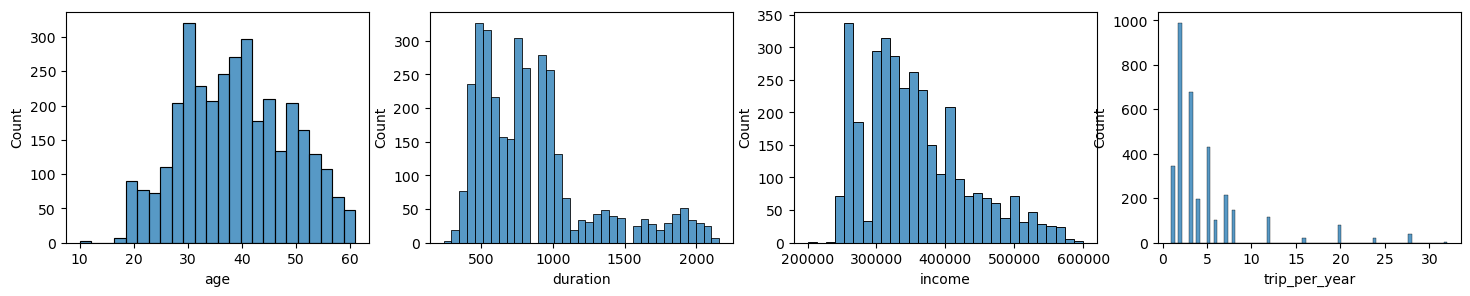

In [245]:
tmp = [
    'age',
    'duration',
    'income',
    'trip_per_year'
]

fig, axes = plt.subplots(1, 4, figsize=(18, 3))
for i, col in enumerate(tmp):
    sns.histplot(df[col], ax=axes[i])

plt.show()

In [248]:
# 対数変換
df['duration'] = np.log1p(df['duration'])
df['income'] = np.log1p(df['income'])
df['trip_per_year'] = np.log1p(df['trip_per_year'])

X = df.drop('ProdTaken', axis=1)
y = df['ProdTaken']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

s_scaler = StandardScaler()
r_scaler = RobustScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[['age']] = s_scaler.fit_transform(X_train[['age']])
X_train_scaled[['duration', 'income', 'trip_per_year']] = r_scaler.fit_transform(X_train[['duration', 'income', 'trip_per_year']])

X_test_scaled[['age']] = s_scaler.transform(X_test[['age']])
X_test_scaled[['duration', 'income', 'trip_per_year']] = r_scaler.transform(X_test[['duration', 'income', 'trip_per_year']])

In [250]:
display(X_train_scaled.head())
display(X_test_scaled.head())

,Passport,age,duration,follow,trip_per_year,income,TypeofContact_Self Enquiry,Occupation_Large Business,Occupation_Small Business,gender_female,...,CityTier_2,NumberOfPersonVisiting_1,NumberOfPersonVisiting_2,NumberOfPersonVisiting_3,PreferredPropertyStar_3,PreferredPropertyStar_4,PitchSatisfactionScore_1,PitchSatisfactionScore_2,PitchSatisfactionScore_3,PitchSatisfactionScore_4
2367,0,1.621831,0.248767,3,-1.000000,0.306774,1,0,1,0,...,1,0,1,0,0,1,1,0,0,0
272,1,-0.913658,-0.639026,4,1.000000,-0.857942,1,1,0,0,...,0,0,1,0,1,0,1,0,0,0
1747,0,1.520411,-0.639026,3,-0.415037,0.199250,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
521,0,-0.000882,-0.843623,4,-0.415037,0.420887,0,0,0,0,...,1,0,1,0,1,0,0,1,0,0
522,0,0.911894,-0.139127,4,-0.415037,-0.490462,0,0,0,0,...,1,0,1,0,1,0,0,1,0,0


,Passport,age,duration,follow,trip_per_year,income,TypeofContact_Self Enquiry,Occupation_Large Business,Occupation_Small Business,gender_female,...,CityTier_2,NumberOfPersonVisiting_1,NumberOfPersonVisiting_2,NumberOfPersonVisiting_3,PreferredPropertyStar_3,PreferredPropertyStar_4,PitchSatisfactionScore_1,PitchSatisfactionScore_2,PitchSatisfactionScore_3,PitchSatisfactionScore_4
3209,0,0.506216,-0.139127,4,1.169925,0.173824,1,1,0,0,...,0,0,0,1,0,1,0,0,0,1
952,0,-0.710819,-0.290349,3,-0.415037,1.665408,1,0,1,0,...,1,0,1,0,0,1,1,0,0,0
3067,1,1.621831,-0.290349,4,0.807355,1.326803,1,0,1,1,...,1,0,0,1,0,0,1,0,0,0
139,0,1.621831,-0.843623,3,-0.415037,0.700216,1,0,0,1,...,1,1,0,0,1,0,0,0,1,0
3192,0,-0.000882,0.000000,4,0.000000,0.024769,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0


# Test Data Preprocessing

In [255]:
df_submit = pd.read_csv('data/test.csv')

In [258]:
# 日本語をすべてInt型に変換
df_submit["age"] = df_submit["Age"].astype(str).apply(japanese_to_int)

# 欠損値を中央値で補完
# japanese_to_int関数により、欠損値は0と出力されている。
tmp = df_submit[~(df_submit["age"] == 0)]
df_submit.loc[df_submit["age"] == 0, "age"] = tmp["age"].median()

In [260]:
# 単位をすべて秒に統一
df_submit["duration"] = df_submit["DurationOfPitch"].dropna().apply(convert_to_second)

# 欠損値を中央値で補完
df_submit["duration"] = df_submit["duration"].fillna(df_submit["duration"].median())

In [263]:
print("NumberOfFollowups : ", df_submit["NumberOfFollowups"].isna().sum())
print("NumberOfTrips : ", df_submit["NumberOfTrips"].isna().sum())
print("MonthlyIncome : ", df_submit["MonthlyIncome"].isna().sum())
print("TypeofContact : ", df_submit["TypeofContact"].isna().sum())

NumberOfFollowups :  24
NumberOfTrips :  42
MonthlyIncome :  49
TypeofContact :  12


# Machine Learning Models

## xgboost

In [266]:
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic')

params = {
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4],
    'gamma': [0.0, 0.1, 0.2, 0.3],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'eta': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400]
}

random_search = RandomizedSearchCV(xgb_classifier, param_distributions=params, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=3, random_state=42, verbose=3)

random_search.fit(X_train_scaled, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best AUC found: ", random_search.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found:  {'subsample': 0.6, 'n_estimators': 400, 'min_child_weight': 2, 'max_depth': 6, 'gamma': 0.2, 'eta': 0.01, 'colsample_bytree': 0.3}
Best AUC found:  0.8175257513869072


In [267]:
# 最適なモデルを取得
best_model = random_search.best_estimator_

# テストデータでの予測
y_pred = best_model.predict_proba(X_test_scaled)[:, 1]

# AUCの計算
auc_score = roc_auc_score(y_test, y_pred)
print(f"Test AUC Score: {auc_score}")

Test AUC Score: 0.844435701098635


## Gradient Boosting Classifier

In [269]:
gbc = GradientBoostingClassifier()

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(gbc, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=2)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best ROC AUC Score:", grid_search.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.05, max_depth=4, n_es